In [2]:
import pandas as pd
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


CSV_PATH = "/content/dataset.csv"
IMG_DIR = "/content/Fracatlas/imagess/imagess"

# Load CSV
df = pd.read_csv(CSV_PATH)

# Ensure image_id has extension
def fix_id(x):
    if not x.lower().endswith((".jpg", ".png")):
        return x + ".jpg"
    return x

df["image_id"] = df["image_id"].apply(fix_id)

# Add full image paths
df["path"] = df["image_id"].apply(lambda x: os.path.join(IMG_DIR, x))

# Keep only images that actually exist
df = df[df["path"].apply(os.path.exists)].reset_index(drop=True)

df.head()


,image_id,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique,path
0,IMG0000000.jpg,0,1,0,0,0,0,1,0,0,1,1,0,/content/Fracatlas/imagess/imagess/IMG0000000.jpg
1,IMG0000001.jpg,0,1,0,0,0,0,1,0,0,1,1,0,/content/Fracatlas/imagess/imagess/IMG0000001.jpg
2,IMG0000002.jpg,0,1,0,0,0,0,1,0,0,1,1,0,/content/Fracatlas/imagess/imagess/IMG0000002.jpg
3,IMG0000003.jpg,0,1,0,0,0,0,1,0,0,0,1,1,/content/Fracatlas/imagess/imagess/IMG0000003.jpg
4,IMG0000004.jpg,0,1,0,0,0,0,1,0,0,0,1,1,/content/Fracatlas/imagess/imagess/IMG0000004.jpg


In [8]:
from google.colab import files
uploaded = files.upload()  # select your zip file


Saving imagess.zip to imagess (1).zip


In [9]:
import zipfile
import os

zip_path = "/content/imagess (1).zip"           # path to your zip
extract_path = "/content/Fracatlas/imagess"  # where to extract

# Create folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check first 20 files
print("Extracted files:", os.listdir(extract_path)[:20])


Extracted files: ['imagess']


In [3]:
df.count()

,0
image_id,4083
hand,4083
leg,4083
hip,4083
shoulder,4083
mixed,4083
hardware,4083
multiscan,4083
fractured,4083
fracture_count,4083


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [5]:
img_dim = (224, 224)
batch = 32
lr_rate = 1e-4
ep = 25


In [6]:
df = df[["path", "fractured"]]


In [7]:
import shutil

merged_folder = "/content/Fracatlas_All"
os.makedirs(merged_folder, exist_ok=True)

for img_path in df["path"]:
    shutil.copy(img_path, os.path.join(merged_folder, os.path.basename(img_path)))


In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["fractured"])
val_df, test_df = train_test_split(temp_df, test_size=0.6667, random_state=42, stratify=temp_df["fractured"])

print(len(train_df), len(val_df), len(test_df))


2858 408 817


In [21]:
# Convert label column to strings
train_df["fractured"] = train_df["fractured"].astype(str)
val_df["fractured"] = val_df["fractured"].astype(str)
test_df["fractured"] = test_df["fractured"].astype(str)


In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="path", y_col="fractured", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="path", y_col="fractured", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)



Found 2858 validated image filenames belonging to 2 classes.
Found 408 validated image filenames belonging to 2 classes.


In [11]:
from tensorflow.keras.applications import ResNet101V2

In [12]:
base_model = ResNet101V2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base_model.layers[:-25]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid")(x)  # binary classification

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [13]:
checkpoint = ModelCheckpoint("f223111_best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")


In [29]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6657 - loss: 0.5985 - val_accuracy: 0.6050 - val_loss: 0.6571

Epoch 2/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6655 - loss: 0.5829 - val_accuracy: 0.6153 - val_loss: 0.6326

Epoch 3/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6848 - loss: 0.5735 - val_accuracy: 0.6200 - val_loss: 0.6171

Epoch 4/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6785 - loss: 0.5576 - val_accuracy: 0.6315 - val_loss: 0.5984

Epoch 5/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7044 - loss: 0.5346 - val_accuracy: 0.6368 - val_loss: 0.5862

Epoch 6/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7031 - loss: 0.5343 - val_accuracy: 0.6636 - val_loss: 0.5726

Epoch 7/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7183 - loss: 0.5151 - val_accuracy: 0.6749 - val_loss: 0.5622

Epoch 8/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7320 - loss: 0.5069 - val_accuracy: 0.6867 - val_loss: 0.5438

Epoch 9/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7361 - loss: 0.4819 - val_accuracy: 0.6838 - val_loss: 0.5335

Epoch 10/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7465 - loss: 0.4735 - val_accuracy: 0.6996 - val_loss: 0.5026

Epoch 11/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7529 - loss: 0.4586 - val_accuracy: 0.7086 - val_loss: 0.4975

Epoch 12/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7657 - loss: 0.4396 - val_accuracy: 0.7270 - val_loss: 0.4868

Epoch 13/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7844 - loss: 0.4181 - val_accuracy: 0.7345 - val_loss: 0.4572

Epoch 14/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7812 - loss: 0.4067 - val_accuracy: 0.7532 - val_loss: 0.4536

Epoch 15/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8039 - loss: 0.4009 - val_accuracy: 0.7677 - val_loss: 0.4420

Epoch 16/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8062 - loss: 0.3842 - val_accuracy: 0.7659 - val_loss: 0.4171

Epoch 17/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8267 - loss: 0.3653 - val_accuracy: 0.7825 - val_loss: 0.3943

Epoch 18/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8275 - loss: 0.3556 - val_accuracy: 0.7997 - val_loss: 0.3785

Epoch 19/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8316 - loss: 0.3402 - val_accuracy: 0.8068 - val_loss: 0.3808

Epoch 20/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8526 - loss: 0.3243 - val_accuracy: 0.8273 - val_loss: 0.3583

Epoch 21/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8498 - loss: 0.3078 - val_accuracy: 0.8357 - val_loss: 0.3445

Epoch 22/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8639 - loss: 0.2998 - val_accuracy: 0.8481 - val_loss: 0.3359

Epoch 23/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8792 - loss: 0.2779 - val_accuracy: 0.8589 - val_loss: 0.3140

Epoch 24/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8894 - loss: 0.2724 - val_accuracy: 0.8649 - val_loss: 0.3002

Epoch 25/25


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9064 - loss: 0.2485 - val_accuracy: 0.8740 - val_loss: 0.2796



In [15]:
model.save("f223111_model.h5")


In [17]:
from tensorflow.keras.models import load_model
model = load_model("f223111_model.h5")


In [22]:
# Test generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, x_col="path", y_col="fractured", target_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, class_mode="binary"
)



Found 817 validated image filenames belonging to 2 classes.


In [23]:
test_df["fractured"] = test_df["fractured"].astype(int)

In [25]:
# Predict
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_df["fractured"].values

# Confusion matrix & classification report
confusion_matrix=confusion_matrix(y_true, y_pred)
print(confusion_matrix)
print(classification_report(y_true, y_pred))

# Plot accuracy & loss



26/26 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step
[[665   9]
 [121  22]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       674
           1       0.71      0.15      0.25       143

    accuracy                           0.84       817
   macro avg       0.78      0.57      0.58       817
weighted avg       0.82      0.84      0.80       817



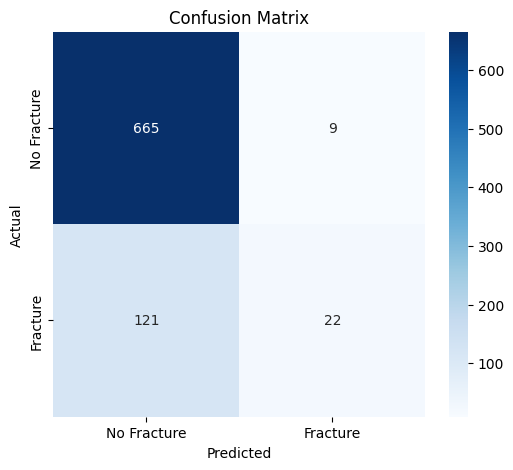

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix
cm = confusion_matrix

# Labels
labels = ["No Fracture", "Fracture"]  #

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


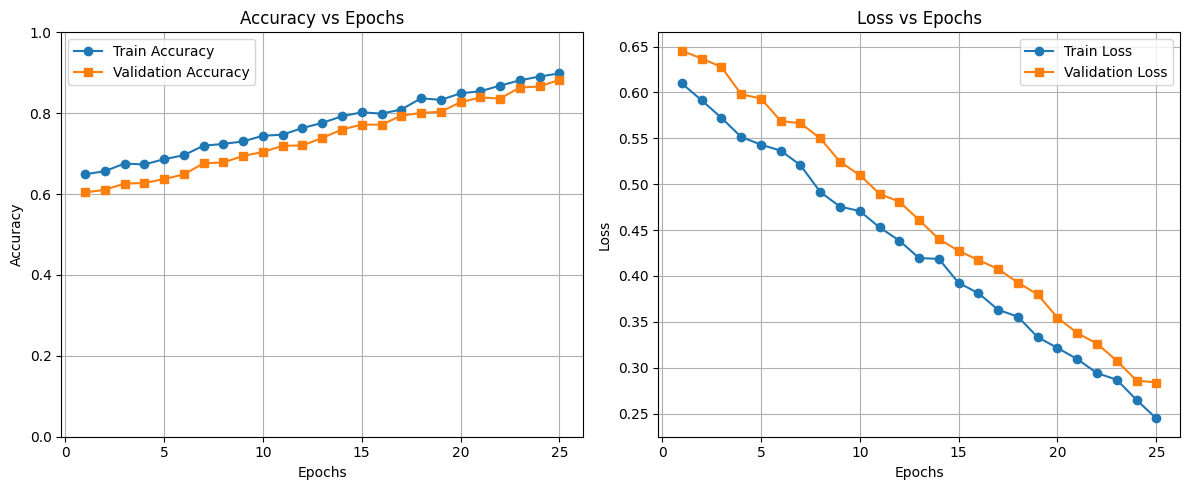

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")
plt.show()